# Plotting Script for showing rasters of Color-MEIs as well as activations

In [3]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_color_mei"
schema = dj.schema("nnfabrik_color_mei")

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *

import nnfabrik
from collections import namedtuple
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlutils.measures import corr

from mlutils.data.datasets import StaticImageSet, FileTreeDataset
from nndichromacy.tables.from_nnfabrik import TrainedModel, DataInfo
from dataport.bcm.static import PreprocessedMouseData
from nnvision.utility.measures import get_explainable_var

from nndichromacy.tables.from_mei import MEI, TrainedEnsembleModel, MEISelector, MEIMethod, MEISeed

Connecting kwilleke@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306


In [90]:
mei_keys = (MEI & dict(dataset_hash='60ca0bb68f0cd4474f498b5a03261ca9', method_hash='02094a069f698ef868c6b2f17d0893e8')).fetch("unit_id", "data_key", order_by='unit_id', as_dict=True, limit=10)

# Reference MEIs: Normalized Images, created with the standard method: Blurring and restricting STD to 0.1

In [85]:

mei_keys_normalized = []
for keys in mei_keys:
    keys["dataset_hash"] = '68db788514e66723ffb230875164d577'
    keys["method_hash"] = 'e203277aa2540dd9f907344ed5babb21'
    mei_keys_normalized.append(keys)

In [88]:
normalized_MEIs = [torch.load(path).detach().cpu().numpy().squeeze() for path in (MEI&mei_keys_normalized).fetch("mei", order_by="unit_id")]

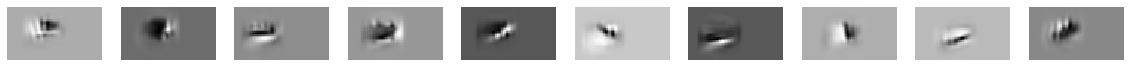

In [89]:
x, axs = plt.subplots(1,10, figsize=(20,5))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(normalized_MEIs[i][0], cmap="gray")
    ax.axis("off")

# Get MEIs with unnormalized Images

In [74]:
MEIs = {}
lr, std, sigma, scores, var_score = [], [], [], [], []
for keys in (MEIMethod & "method_ts < '2020-06-03'"):
    keys.update(dict(dataset_hash='60ca0bb68f0cd4474f498b5a03261ca9'))
    
    lr_i = keys["method_config"]["optimizer"]["kwargs"]["lr"]
    lr.append(lr_i)
    
    sigma_i = keys["method_config"]["precondition"]["kwargs"]["sigma"]
    sigma.append(sigma_i)
    
    std_i = keys["method_config"]["postprocessing"]["kwargs"]["std"]
    std.append(std_i)
    
    scores.append((MEI&keys).fetch("score").mean())
    var_score.append((MEI&keys).fetch("score").std())
    MEIs[f"{lr_i}_{std_i}_{sigma_i}"] = [torch.load(path).detach().cpu().numpy().squeeze() for path in (MEI&keys).fetch("mei", order_by="unit_id")]

In [81]:
import pandas as pd
df = pd.DataFrame({'activation': scores, 
                   'activation variance': var_score,
                   'lr': lr,
                   'std': std,
                   'sigma': sigma})

# Mean MEI Activations for 10 Neurons - Unnormalized

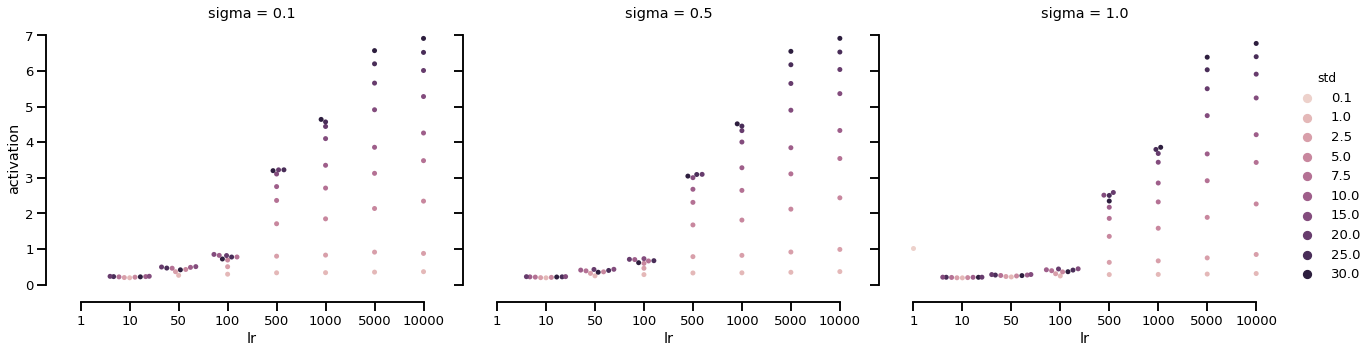

In [82]:
sns.set_context('talk', font_scale=0.8)

sns.catplot(x="lr", y="activation", hue="std",
            aspect=1.2, legend_out=True,
            col="sigma",
            kind="swarm", data=df, palette=sns.cubehelix_palette(10));
sns.despine(trim=True, offset=10)

# MEI Activation STD across 10 neurons

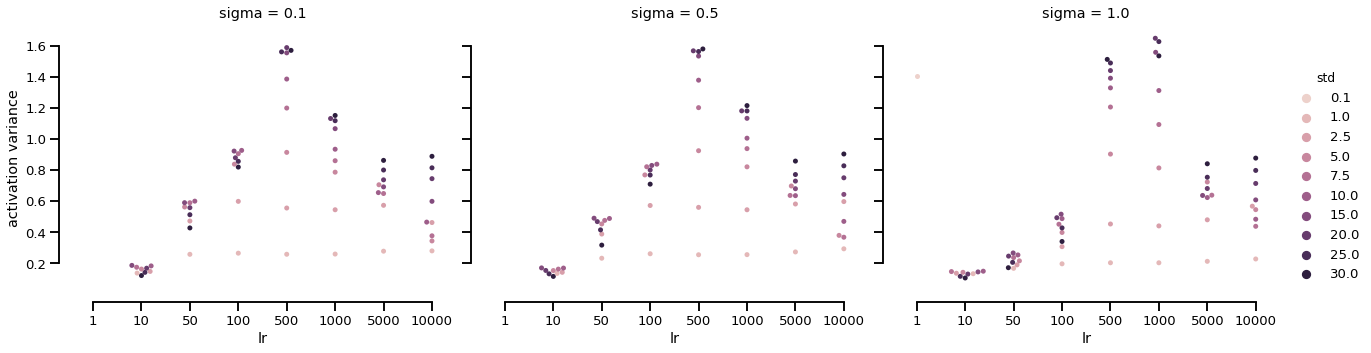

In [85]:
sns.set_context('talk', font_scale=0.8)

std_ordered = np.sort(np.unique(std))
sns.catplot(x="lr", y="activation variance", hue="std",
            aspect=1.2, legend_out=True,
            col="sigma",
            kind="swarm", data=df, palette=sns.cubehelix_palette(10));
sns.despine(trim=True, offset=10)

# Activations without separations by Sigma

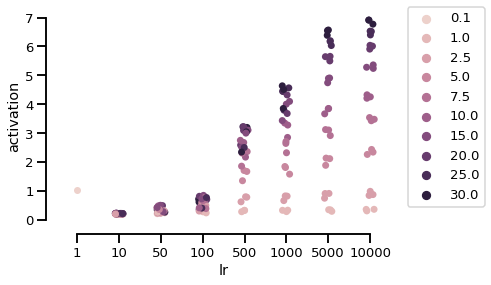

In [83]:
sns.set_context('talk', font_scale=0.8)

std_ordered = np.sort(np.unique(std))
sns.stripplot(x="lr", y="activation", hue="std", size=7,
           data=df, palette=sns.cubehelix_palette(10));
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(trim=True, offset=10)

# Plotting the MEIs for a single settings

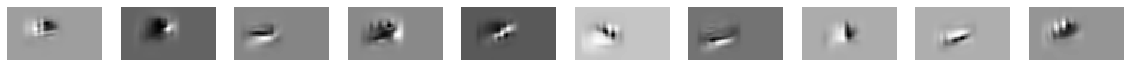

In [175]:
mei_lr = 10000
mei_std = 5
mei_sigma = 1
MEI_subset = MEIs[f"{mei_lr}_{mei_std}_{mei_sigma}"]

fix, axs = plt.subplots(1,10, figsize=(20,5))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(MEI_subset[i][0], cmap="gray")
    ax.axis("off")

# Plotting STD

In these plots, the LR is fixed to one value, and the rows represent different STD constraints

# Scaled to 0 - 255 px

### lr = 1000

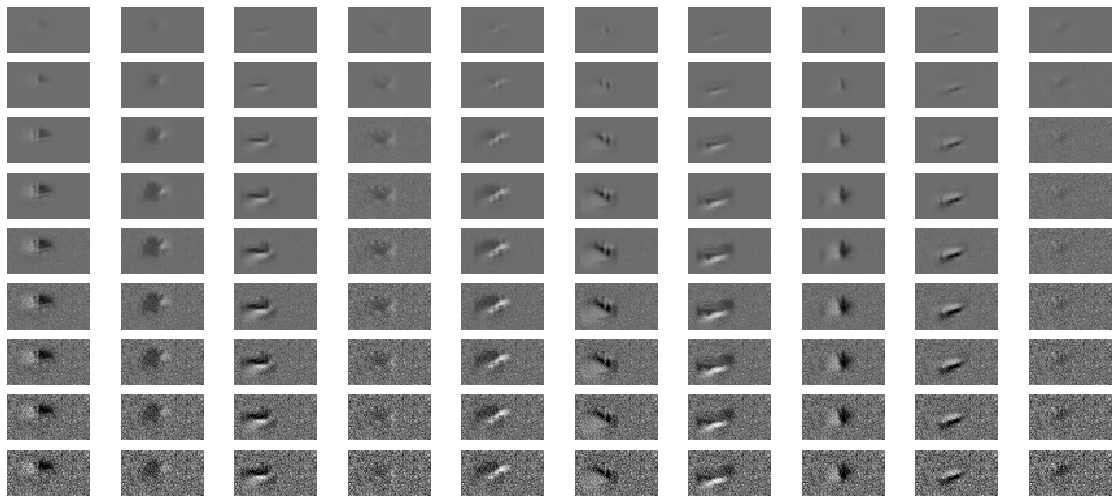

In [127]:
mei_lr = 1000
mei_std = [1, 2.5, 5, 7.5, 10, 15, 20, 25, 30]
mei_sigma = 1
MEI_subset = []
for std_i in mei_std:
    MEI_subset.extend(MEIs[f"{mei_lr}_{std_i}_{mei_sigma}"])


n_rows = len(MEI_subset) // 10
fix, axs = plt.subplots(n_rows,10, figsize=(20, n_rows))
for i, ax in enumerate(axs.ravel()):
    mei = MEI_subset[i][0]
    vmax = np.max(np.abs(mei))
    ax.imshow(mei, cmap="gray", vmin=0, vmax=255)
    ax.axis("off")

### lr = 10000

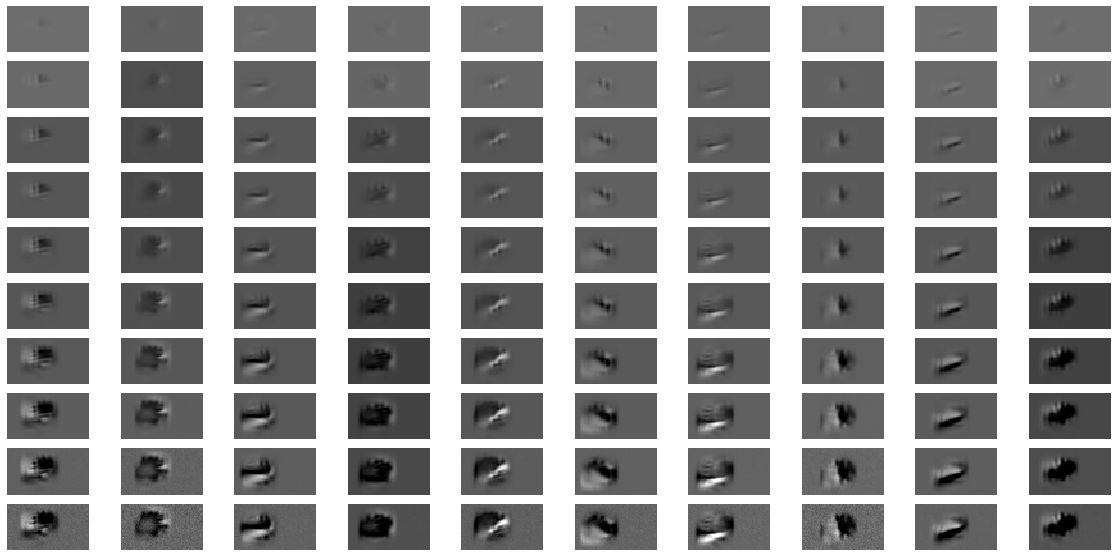

In [128]:

mei_lr = 10000
mei_std = [1, 2.5, 5, 7.5, 10, 15, 20, 25, 30]
mei_sigma = 1
MEI_subset = []
for std_i in mei_std:
    MEI_subset.extend(MEIs[f"{mei_lr}_{std_i}_{mei_sigma}"])


n_rows = len(MEI_subset) // 10
fix, axs = plt.subplots(n_rows,10, figsize=(20, n_rows))
for i, ax in enumerate(axs.ravel()):
    mei = MEI_subset[i][0]
    vmax = np.max(np.abs(mei))
    ax.imshow(mei, cmap="gray", vmin=0, vmax=255)
    ax.axis("off")

## Scaled to [min, max]

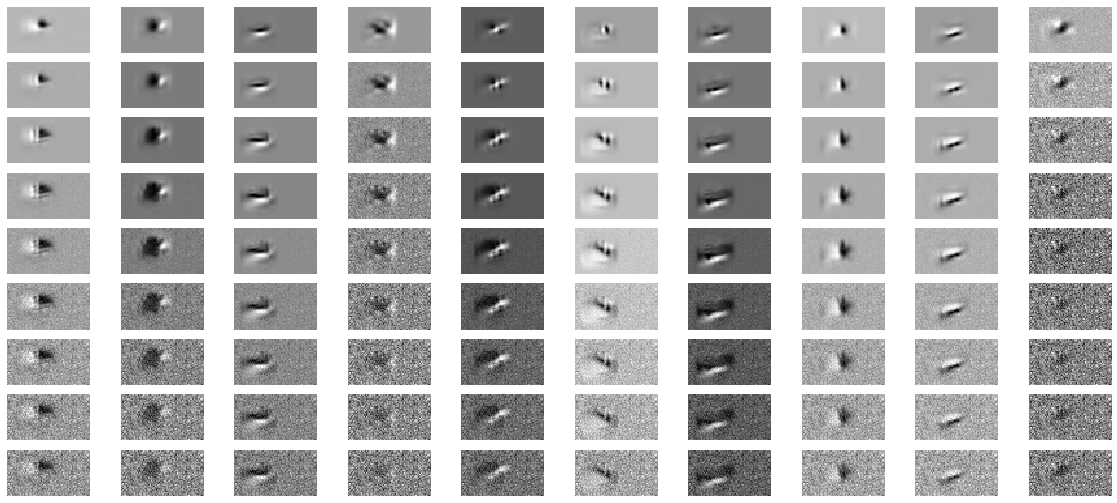

In [133]:

mei_lr = 1000
mei_std = [1, 2.5, 5, 7.5, 10, 15, 20, 25, 30]
mei_sigma = 1
MEI_subset = []
for std_i in mei_std:
    MEI_subset.extend(MEIs[f"{mei_lr}_{std_i}_{mei_sigma}"])


n_rows = len(MEI_subset) // 10
fix, axs = plt.subplots(n_rows,10, figsize=(20, n_rows))
for i, ax in enumerate(axs.ravel()):
    mei = MEI_subset[i][0]
    vmax = np.max(np.abs(mei))
    ax.imshow(mei, cmap="gray")
    ax.axis("off")

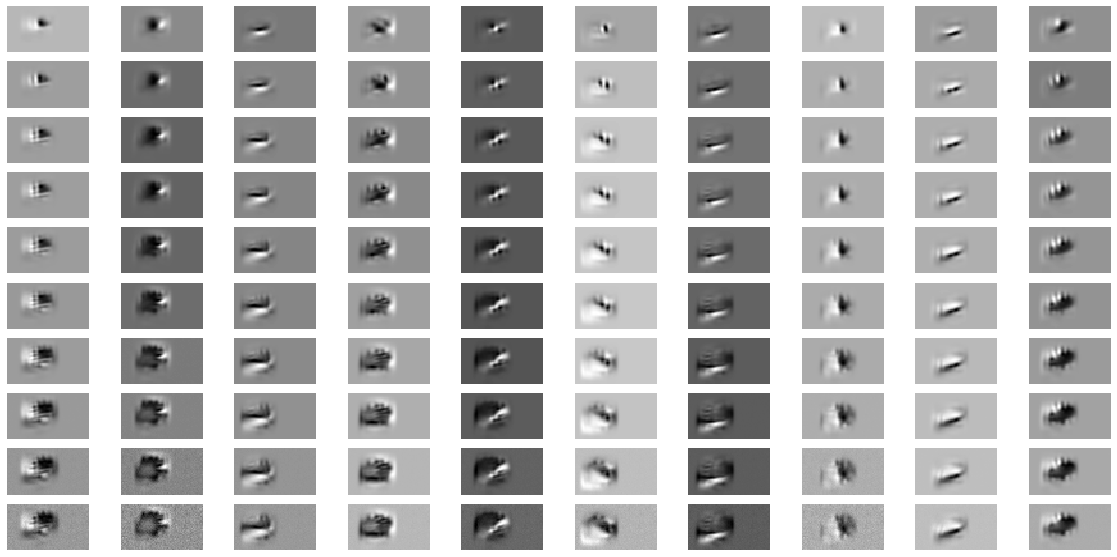

In [129]:

mei_lr = 10000
mei_std = [1, 2.5, 5, 7.5, 10, 15, 20, 25, 30]
mei_sigma = 1
MEI_subset = []
for std_i in mei_std:
    MEI_subset.extend(MEIs[f"{mei_lr}_{std_i}_{mei_sigma}"])


n_rows = len(MEI_subset) // 10
fix, axs = plt.subplots(n_rows,10, figsize=(20, n_rows))
for i, ax in enumerate(axs.ravel()):
    mei = MEI_subset[i][0]
    vmax = np.max(np.abs(mei))
    ax.imshow(mei, cmap="gray")
    ax.axis("off")

# Plotting LR

### STD = 1

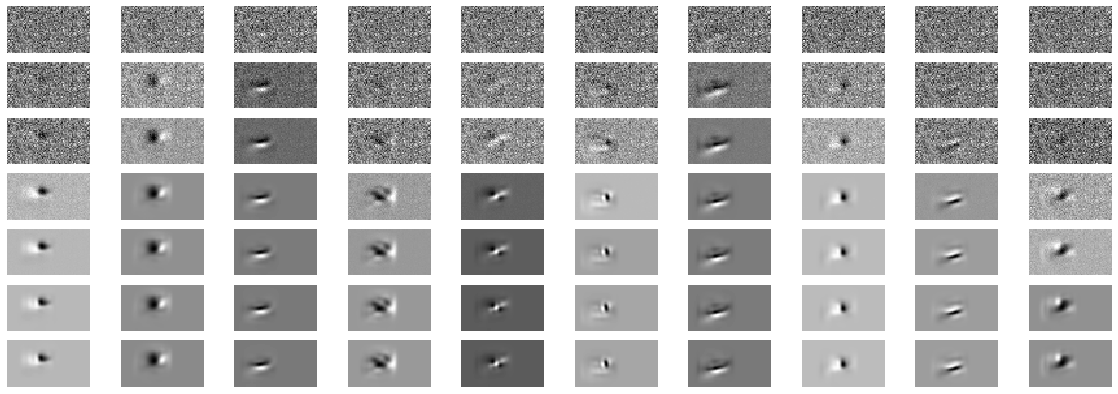

In [131]:

mei_lr = [10,50,100,500, 1000, 5000, 10000]
mei_std = 1
mei_sigma = 1
MEI_subset = []
for lr_i in mei_lr:
    MEI_subset.extend(MEIs[f"{lr_i}_{mei_std}_{mei_sigma}"])


n_rows = len(MEI_subset) // 10
fix, axs = plt.subplots(n_rows,10, figsize=(20, n_rows))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(MEI_subset[i][0], cmap="gray")
    ax.axis("off")

### STD = 5

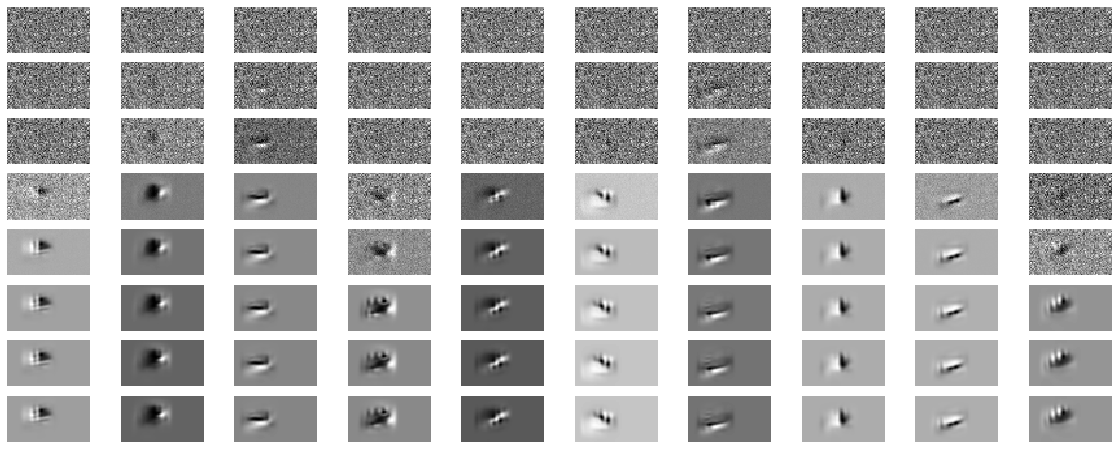

In [132]:

mei_lr = [10,50,100,500, 1000, 5000, 10000]
mei_std = 5
mei_sigma = 1
MEI_subset = []
for lr_i in mei_lr:
    MEI_subset.extend(MEIs[f"{lr_i}_{mei_std}_{mei_sigma}"])


n_rows = len(MEI_subset) // 10
fix, axs = plt.subplots(n_rows,10, figsize=(20, n_rows))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(MEI_subset[i][0], cmap="gray")
    ax.axis("off")

# Reference MEIs: Normalized Images, created with the standard method: Blurring and restricting STD to 0.1

In [85]:

mei_keys_normalized = []
for keys in mei_keys:
    keys["dataset_hash"] = '68db788514e66723ffb230875164d577'
    keys["method_hash"] = 'e203277aa2540dd9f907344ed5babb21'
    mei_keys_normalized.append(keys)

In [88]:
normalized_MEIs = [torch.load(path).detach().cpu().numpy().squeeze() for path in (MEI&mei_keys_normalized).fetch("mei", order_by="unit_id")]

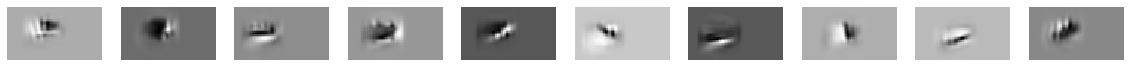

In [89]:
x, axs = plt.subplots(1,10, figsize=(20,5))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(normalized_MEIs[i][0], cmap="gray")
    ax.axis("off")

# Comparing that to the closest Matching Unnormalized Method

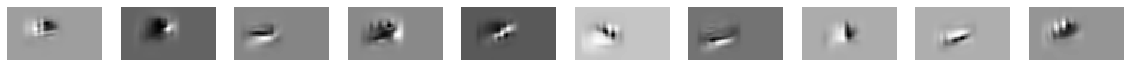

In [92]:

mei_lr = 10000
mei_std = 5
mei_sigma = 1
MEI_subset = MEIs[f"{mei_lr}_{mei_std}_{mei_sigma}"]

fix, axs = plt.subplots(1,10, figsize=(20,5))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(MEI_subset[i][0], cmap="gray")
    ax.axis("off")

# Normalized MEIs - getting lr/stds for one neuron

In [66]:
method_hashes = ['03d17b935c6b174230ee5fc6b7490c3a',
 '180c3181898d04bee17be0bbf92b1dd2',
 '2364056c96a488d0c7ab9723ba1bc423',
 '2a3472a217e4269a5ba13604f95752e2',
 '30b451de0de0e1cea16bde20f371d669',
 '341f3f02e3723df81386903c0d5e35e1',
 '35e0563de6dbcfd171770a65e4c104b2',
 '37cfb7611ce247a8b21340d289911a57',
 '392d40cfdd604e97144f7519a9a7823c',
 '3d3b34be116bc13f33ef385123191d1d',
 '47cd5342c40ee2f950cf3388af912ee2',
 '4a17f4bc1091e211c733178b56a8d256',
 '4e5867efac541cd706f37cf59097c20d',
 '62fb6421fd8629426248bb4bc512e719',
 '64335fc4cc8ccb96f1268e9481118a29',
 '664eadaa37685742ff76b753ce2f5678',
 '689ead756db57200b6f47a01f09d1639',
 '6ea8b816fe54d4fd5f10c8fce97f26f8',
 '7680891ff3b7031e25b0a05aa7cd930a',
 '7ea28dcbc4410aefb4e953659615f121',
 '8177936e2997f2a078097920dc5d79cd',
 '8d20746240bddafbaa022d52c61aac8c',
 '96f84a8729370c72f5ec85d91365db1a',
 '9bc287285085e30d147863908918320a',
 'a9c47c1781b6022c41bcd32cf1f7ebd3',
 'b50debf12d1b9224701ec2b23c64bf15',
 'c86e97bd8efb6df0c5efb5b56f198efa',
 'd83125b22ec25c989f083de0ab577b13',
 'e12d4ed0ac950d72c18b2ba486d51021',
 'e50b649584017c89dc72dfa46f9b77c3',
 'e7681e631634391ce5a03ea213408762',
 'ef6a4e0ef467e25f126d2252fabafbf1',
 'f91fe56a7cd5a3e1e251d9808a7a5958',
 'fcfadbbb4ef51f3824b996bcb6b646ab',
 'ff0d901b74091e5937c64ab23504aac6']

mei_keys_normalized = []
for method_hash in method_hashes:
    mei_keys_normalized.append(dict(unit_id=21, dataset_hash='68db788514e66723ffb230875164d577', method_hash=method_hash))

In [69]:
MEIs = {}
lr, std, sigma, scores, var_score = [], [], [], [], []
for keys in (MEIMethod & mei_keys_normalized):
    keys.update(dict(dataset_hash='68db788514e66723ffb230875164d577', unit_id=21))
    
    if len(MEI&keys)>0:
        lr_i = keys["method_config"]["optimizer"]["kwargs"]["lr"]
        lr.append(lr_i)

        sigma_i = keys["method_config"]["precondition"]["kwargs"]["sigma"]
        sigma.append(sigma_i)

        std_i = keys["method_config"]["postprocessing"]["kwargs"]["std"]
        std.append(std_i)

        scores.append((MEI&keys).fetch("score"))
        MEIs[f"{lr_i}_{std_i}_{sigma_i}"] = [torch.load(path).detach().cpu().numpy().squeeze() for path in (MEI&keys).fetch("mei", order_by="unit_id")]

In [70]:
import pandas as pd
df_normalized = pd.DataFrame({'activation': scores, 
                   'lr': lr,
                   'std': std,
                   'sigma': sigma,
                })


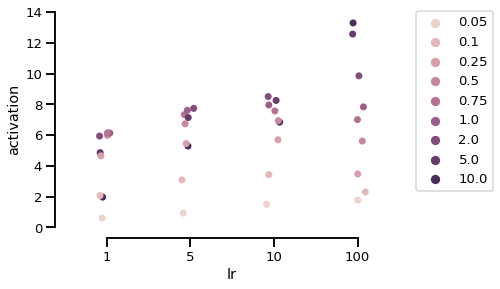

In [50]:
sns.set_context('talk', font_scale=0.8)

std_ordered = np.sort(np.unique(std))
sns.stripplot(x="lr", y="activation", hue="std", size=7,
           data=df_normalized, palette=sns.cubehelix_palette(10));

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(trim=True, offset=10)

In [52]:
MEI_subset = []
for lr in [1, 5, 10, 100]:
    for std in [0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]:
        MEI_subset.extend(MEIs[f"{lr}_{std}_{mei_sigma}"])

# LRs vs STD for one neuron - Normalized Images

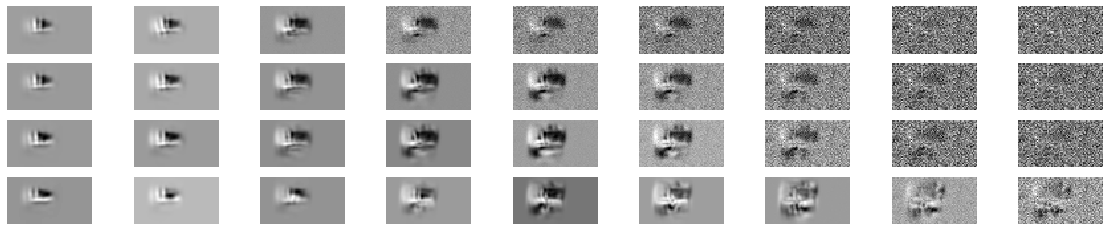

In [54]:
fix, axs = plt.subplots(4,9, figsize=(20, 4))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(MEI_subset[i][0], cmap="gray")
    ax.axis("off")